In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path  = '/content/drive/MyDrive/Projects/HDA Proj/mini_dataset'

In [4]:
class OCTDataLoader:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=64):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def get_loaders(self):
        # Load train and test datasets with appropriate transformations
        try:
            train_dataset = datasets.ImageFolder(f'{self.data_dir}/train', transform=self.train_transform)
            test_dataset = datasets.ImageFolder(f'{self.data_dir}/test', transform=self.test_transform)
        except FileNotFoundError as e:
            print("Error: One of the required directories or files is missing.")
            raise e

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        return train_loader, test_loader

In [5]:
# Usage example
data_loader = OCTDataLoader(data_dir=path, img_size=(224, 224), batch_size=96)
train_loader, test_loader = data_loader.get_loaders()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
import time

class EfficientNetTrainer:
    def __init__(self, train_loader, num_classes=4, learning_rate=0.001, device=None):
        self.train_loader = train_loader
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.load_model(num_classes).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.num_classes = num_classes

    def load_model(self, num_classes):
        # Load EfficientNet with pretrained weights and adjust the classifier layer
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(tqdm(self.train_loader), 1):
            start_time = time.time()
            images, labels = images.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Calculate time per batch
            batch_time = time.time() - start_time

            # Print progress for each batch
            avg_loss = running_loss / batch_idx
            accuracy = 100 * correct / total
            print(f"Batch {batch_idx}: Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time/Batch: {batch_time:.2f}s")

        return avg_loss, accuracy

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            avg_loss, accuracy = self.train_one_epoch()
            print(f"Epoch {epoch+1} completed. Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")




In [7]:
# Usage example
trainer = EfficientNetTrainer(train_loader=train_loader, num_classes=4, learning_rate=0.001)
trainer.train(num_epochs=3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 45.7MB/s]



Epoch 1/3


  1%|          | 1/87 [01:17<1:51:07, 77.53s/it]

Batch 1: Loss: 1.4013, Accuracy: 22.92%, Time/Batch: 2.22s


  2%|▏         | 2/87 [01:17<45:35, 32.18s/it]  

Batch 2: Loss: 1.2763, Accuracy: 42.19%, Time/Batch: 0.43s


  3%|▎         | 3/87 [01:32<34:02, 24.31s/it]

Batch 3: Loss: 1.1786, Accuracy: 51.04%, Time/Batch: 0.49s


  5%|▍         | 4/87 [01:33<20:35, 14.89s/it]

Batch 4: Loss: 1.0979, Accuracy: 54.95%, Time/Batch: 0.43s


  6%|▌         | 5/87 [01:49<20:48, 15.23s/it]

Batch 5: Loss: 1.0485, Accuracy: 57.50%, Time/Batch: 0.49s


  7%|▋         | 6/87 [01:49<13:46, 10.20s/it]

Batch 6: Loss: 0.9737, Accuracy: 60.76%, Time/Batch: 0.43s


  8%|▊         | 7/87 [02:05<15:57, 11.97s/it]

Batch 7: Loss: 0.9229, Accuracy: 63.24%, Time/Batch: 0.51s


  9%|▉         | 8/87 [02:05<10:55,  8.30s/it]

Batch 8: Loss: 0.8637, Accuracy: 65.76%, Time/Batch: 0.44s


 10%|█         | 9/87 [02:20<13:22, 10.29s/it]

Batch 9: Loss: 0.8132, Accuracy: 68.06%, Time/Batch: 0.50s


 11%|█▏        | 10/87 [02:20<09:18,  7.25s/it]

Batch 10: Loss: 0.7716, Accuracy: 69.90%, Time/Batch: 0.44s


 13%|█▎        | 11/87 [02:34<11:45,  9.29s/it]

Batch 11: Loss: 0.7429, Accuracy: 71.02%, Time/Batch: 0.46s


 14%|█▍        | 12/87 [02:35<08:14,  6.60s/it]

Batch 12: Loss: 0.7085, Accuracy: 72.57%, Time/Batch: 0.44s


 15%|█▍        | 13/87 [02:50<11:28,  9.31s/it]

Batch 13: Loss: 0.6831, Accuracy: 73.88%, Time/Batch: 0.50s


 16%|█▌        | 14/87 [02:51<08:04,  6.63s/it]

Batch 14: Loss: 0.6526, Accuracy: 75.07%, Time/Batch: 0.44s


 17%|█▋        | 15/87 [03:05<10:56,  9.11s/it]

Batch 15: Loss: 0.6363, Accuracy: 75.83%, Time/Batch: 0.48s


 18%|█▊        | 16/87 [03:06<07:41,  6.50s/it]

Batch 16: Loss: 0.6143, Accuracy: 76.95%, Time/Batch: 0.44s


 20%|█▉        | 17/87 [03:23<11:22,  9.76s/it]

Batch 17: Loss: 0.6032, Accuracy: 77.63%, Time/Batch: 0.47s


 21%|██        | 18/87 [03:24<08:00,  6.96s/it]

Batch 18: Loss: 0.5833, Accuracy: 78.47%, Time/Batch: 0.44s


 22%|██▏       | 19/87 [03:39<10:52,  9.60s/it]

Batch 19: Loss: 0.5772, Accuracy: 79.00%, Time/Batch: 0.48s


 23%|██▎       | 20/87 [03:40<07:39,  6.85s/it]

Batch 20: Loss: 0.5686, Accuracy: 79.53%, Time/Batch: 0.44s


 24%|██▍       | 21/87 [03:57<10:46,  9.79s/it]

Batch 21: Loss: 0.5573, Accuracy: 79.96%, Time/Batch: 0.48s


 25%|██▌       | 22/87 [03:57<07:33,  6.98s/it]

Batch 22: Loss: 0.5442, Accuracy: 80.49%, Time/Batch: 0.44s


 26%|██▋       | 23/87 [04:12<09:54,  9.28s/it]

Batch 23: Loss: 0.5311, Accuracy: 80.80%, Time/Batch: 0.48s


 28%|██▊       | 24/87 [04:12<06:57,  6.63s/it]

Batch 24: Loss: 0.5302, Accuracy: 81.08%, Time/Batch: 0.45s


 29%|██▊       | 25/87 [04:28<09:39,  9.34s/it]

Batch 25: Loss: 0.5205, Accuracy: 81.50%, Time/Batch: 0.47s


 30%|██▉       | 26/87 [04:28<06:47,  6.67s/it]

Batch 26: Loss: 0.5125, Accuracy: 81.77%, Time/Batch: 0.45s


 31%|███       | 27/87 [04:44<09:21,  9.36s/it]

Batch 27: Loss: 0.5051, Accuracy: 82.06%, Time/Batch: 0.48s


 32%|███▏      | 28/87 [04:44<06:34,  6.68s/it]

Batch 28: Loss: 0.4992, Accuracy: 82.29%, Time/Batch: 0.45s


 33%|███▎      | 29/87 [04:58<08:34,  8.87s/it]

Batch 29: Loss: 0.4956, Accuracy: 82.58%, Time/Batch: 0.50s


 34%|███▍      | 30/87 [04:59<06:01,  6.34s/it]

Batch 30: Loss: 0.4958, Accuracy: 82.50%, Time/Batch: 0.45s


 36%|███▌      | 31/87 [05:13<08:11,  8.78s/it]

Batch 31: Loss: 0.4940, Accuracy: 82.63%, Time/Batch: 0.48s


 37%|███▋      | 32/87 [05:14<05:45,  6.29s/it]

Batch 32: Loss: 0.4866, Accuracy: 82.88%, Time/Batch: 0.45s


 38%|███▊      | 33/87 [05:29<08:04,  8.96s/it]

Batch 33: Loss: 0.4854, Accuracy: 83.02%, Time/Batch: 0.48s


 39%|███▉      | 34/87 [05:29<05:39,  6.41s/it]

Batch 34: Loss: 0.4812, Accuracy: 83.21%, Time/Batch: 0.45s


 40%|████      | 35/87 [05:44<07:37,  8.79s/it]

Batch 35: Loss: 0.4798, Accuracy: 83.33%, Time/Batch: 0.51s


 41%|████▏     | 36/87 [05:44<05:20,  6.29s/it]

Batch 36: Loss: 0.4742, Accuracy: 83.48%, Time/Batch: 0.46s


 43%|████▎     | 37/87 [05:59<07:17,  8.74s/it]

Batch 37: Loss: 0.4705, Accuracy: 83.56%, Time/Batch: 0.49s


 44%|████▎     | 38/87 [05:59<05:06,  6.26s/it]

Batch 38: Loss: 0.4673, Accuracy: 83.69%, Time/Batch: 0.46s


 45%|████▍     | 39/87 [06:12<06:42,  8.38s/it]

Batch 39: Loss: 0.4625, Accuracy: 83.81%, Time/Batch: 0.50s


 46%|████▌     | 40/87 [06:13<04:42,  6.00s/it]

Batch 40: Loss: 0.4558, Accuracy: 84.09%, Time/Batch: 0.46s


 47%|████▋     | 41/87 [06:28<06:39,  8.68s/it]

Batch 41: Loss: 0.4526, Accuracy: 84.25%, Time/Batch: 0.47s


 48%|████▊     | 42/87 [06:28<04:39,  6.21s/it]

Batch 42: Loss: 0.4494, Accuracy: 84.33%, Time/Batch: 0.45s


 49%|████▉     | 43/87 [06:42<06:07,  8.35s/it]

Batch 43: Loss: 0.4473, Accuracy: 84.35%, Time/Batch: 0.50s


 51%|█████     | 44/87 [06:42<04:17,  5.98s/it]

Batch 44: Loss: 0.4408, Accuracy: 84.56%, Time/Batch: 0.45s


 52%|█████▏    | 45/87 [07:01<06:49,  9.75s/it]

Batch 45: Loss: 0.4351, Accuracy: 84.75%, Time/Batch: 0.48s


 53%|█████▎    | 46/87 [07:01<04:45,  6.96s/it]

Batch 46: Loss: 0.4323, Accuracy: 84.85%, Time/Batch: 0.45s


 54%|█████▍    | 47/87 [07:14<05:52,  8.81s/it]

Batch 47: Loss: 0.4269, Accuracy: 85.04%, Time/Batch: 0.49s


 55%|█████▌    | 48/87 [07:15<04:05,  6.30s/it]

Batch 48: Loss: 0.4218, Accuracy: 85.24%, Time/Batch: 0.45s


 56%|█████▋    | 49/87 [07:29<05:35,  8.84s/it]

Batch 49: Loss: 0.4169, Accuracy: 85.35%, Time/Batch: 0.50s


 57%|█████▋    | 50/87 [07:30<03:54,  6.33s/it]

Batch 50: Loss: 0.4161, Accuracy: 85.42%, Time/Batch: 0.45s


 59%|█████▊    | 51/87 [07:47<05:46,  9.63s/it]

Batch 51: Loss: 0.4120, Accuracy: 85.56%, Time/Batch: 0.48s


 60%|█████▉    | 52/87 [07:48<04:00,  6.88s/it]

Batch 52: Loss: 0.4089, Accuracy: 85.64%, Time/Batch: 0.45s


 61%|██████    | 53/87 [08:03<05:25,  9.57s/it]

Batch 53: Loss: 0.4071, Accuracy: 85.75%, Time/Batch: 0.48s


 62%|██████▏   | 54/87 [08:04<03:45,  6.83s/it]

Batch 54: Loss: 0.4024, Accuracy: 85.92%, Time/Batch: 0.45s


 63%|██████▎   | 55/87 [08:17<04:43,  8.85s/it]

Batch 55: Loss: 0.4022, Accuracy: 85.97%, Time/Batch: 0.50s


 64%|██████▍   | 56/87 [08:18<03:16,  6.33s/it]

Batch 56: Loss: 0.3979, Accuracy: 86.10%, Time/Batch: 0.46s


 66%|██████▌   | 57/87 [08:32<04:20,  8.70s/it]

Batch 57: Loss: 0.3948, Accuracy: 86.18%, Time/Batch: 0.50s


 67%|██████▋   | 58/87 [08:33<03:00,  6.22s/it]

Batch 58: Loss: 0.3918, Accuracy: 86.30%, Time/Batch: 0.45s


 68%|██████▊   | 59/87 [08:49<04:17,  9.19s/it]

Batch 59: Loss: 0.3894, Accuracy: 86.35%, Time/Batch: 0.48s


 69%|██████▉   | 60/87 [08:49<02:57,  6.57s/it]

Batch 60: Loss: 0.3856, Accuracy: 86.48%, Time/Batch: 0.45s


 70%|███████   | 61/87 [09:05<04:04,  9.39s/it]

Batch 61: Loss: 0.3827, Accuracy: 86.56%, Time/Batch: 0.50s


 71%|███████▏  | 62/87 [09:06<02:47,  6.71s/it]

Batch 62: Loss: 0.3790, Accuracy: 86.68%, Time/Batch: 0.45s


 72%|███████▏  | 63/87 [09:21<03:40,  9.20s/it]

Batch 63: Loss: 0.3808, Accuracy: 86.64%, Time/Batch: 0.51s


 74%|███████▎  | 64/87 [09:21<02:31,  6.57s/it]

Batch 64: Loss: 0.3776, Accuracy: 86.78%, Time/Batch: 0.45s


 75%|███████▍  | 65/87 [09:36<03:17,  9.00s/it]

Batch 65: Loss: 0.3754, Accuracy: 86.88%, Time/Batch: 0.51s


 76%|███████▌  | 66/87 [09:36<02:15,  6.43s/it]

Batch 66: Loss: 0.3723, Accuracy: 86.99%, Time/Batch: 0.45s


 77%|███████▋  | 67/87 [09:51<02:56,  8.84s/it]

Batch 67: Loss: 0.3688, Accuracy: 87.11%, Time/Batch: 0.50s


 78%|███████▊  | 68/87 [09:51<02:00,  6.33s/it]

Batch 68: Loss: 0.3664, Accuracy: 87.19%, Time/Batch: 0.46s


 79%|███████▉  | 69/87 [10:05<02:37,  8.74s/it]

Batch 69: Loss: 0.3642, Accuracy: 87.24%, Time/Batch: 0.50s


 80%|████████  | 70/87 [10:06<01:46,  6.26s/it]

Batch 70: Loss: 0.3635, Accuracy: 87.31%, Time/Batch: 0.45s


 82%|████████▏ | 71/87 [10:20<02:20,  8.78s/it]

Batch 71: Loss: 0.3611, Accuracy: 87.35%, Time/Batch: 0.51s


 83%|████████▎ | 72/87 [10:21<01:34,  6.28s/it]

Batch 72: Loss: 0.3592, Accuracy: 87.40%, Time/Batch: 0.46s


 84%|████████▍ | 73/87 [10:36<02:03,  8.79s/it]

Batch 73: Loss: 0.3596, Accuracy: 87.47%, Time/Batch: 0.50s


 85%|████████▌ | 74/87 [10:36<01:21,  6.29s/it]

Batch 74: Loss: 0.3584, Accuracy: 87.47%, Time/Batch: 0.45s


 86%|████████▌ | 75/87 [10:48<01:37,  8.13s/it]

Batch 75: Loss: 0.3573, Accuracy: 87.50%, Time/Batch: 0.49s


 87%|████████▋ | 76/87 [10:49<01:04,  5.83s/it]

Batch 76: Loss: 0.3583, Accuracy: 87.50%, Time/Batch: 0.45s


 89%|████████▊ | 77/87 [11:10<01:43, 10.35s/it]

Batch 77: Loss: 0.3578, Accuracy: 87.50%, Time/Batch: 0.47s


 90%|████████▉ | 78/87 [11:10<01:06,  7.38s/it]

Batch 78: Loss: 0.3549, Accuracy: 87.58%, Time/Batch: 0.46s


 91%|█████████ | 79/87 [11:30<01:27, 10.94s/it]

Batch 79: Loss: 0.3534, Accuracy: 87.63%, Time/Batch: 0.47s


 92%|█████████▏| 80/87 [11:30<00:54,  7.80s/it]

Batch 80: Loss: 0.3521, Accuracy: 87.64%, Time/Batch: 0.45s


 93%|█████████▎| 81/87 [11:44<00:58,  9.70s/it]

Batch 81: Loss: 0.3517, Accuracy: 87.63%, Time/Batch: 0.50s


 94%|█████████▍| 82/87 [11:45<00:34,  6.93s/it]

Batch 82: Loss: 0.3534, Accuracy: 87.65%, Time/Batch: 0.46s


 95%|█████████▌| 83/87 [12:00<00:37,  9.50s/it]

Batch 83: Loss: 0.3516, Accuracy: 87.73%, Time/Batch: 0.48s


 97%|█████████▋| 84/87 [12:01<00:20,  6.79s/it]

Batch 84: Loss: 0.3506, Accuracy: 87.80%, Time/Batch: 0.46s


 98%|█████████▊| 85/87 [12:16<00:18,  9.37s/it]

Batch 85: Loss: 0.3493, Accuracy: 87.88%, Time/Batch: 0.48s


 99%|█████████▉| 86/87 [12:16<00:06,  6.70s/it]

Batch 86: Loss: 0.3492, Accuracy: 87.91%, Time/Batch: 0.45s


100%|██████████| 87/87 [12:29<00:00,  8.62s/it]


Batch 87: Loss: 0.3488, Accuracy: 87.92%, Time/Batch: 0.45s
Epoch 1 completed. Loss: 0.3488, Accuracy: 87.92%

Epoch 2/3


  1%|          | 1/87 [00:01<02:42,  1.89s/it]

Batch 1: Loss: 0.2167, Accuracy: 89.58%, Time/Batch: 0.47s


  2%|▏         | 2/87 [00:02<01:30,  1.06s/it]

Batch 2: Loss: 0.2020, Accuracy: 92.71%, Time/Batch: 0.47s


  3%|▎         | 3/87 [00:03<01:32,  1.10s/it]

Batch 3: Loss: 0.2007, Accuracy: 92.71%, Time/Batch: 0.46s


  5%|▍         | 4/87 [00:03<01:10,  1.17it/s]

Batch 4: Loss: 0.2317, Accuracy: 92.45%, Time/Batch: 0.47s


  6%|▌         | 5/87 [00:05<01:19,  1.03it/s]

Batch 5: Loss: 0.2296, Accuracy: 92.71%, Time/Batch: 0.46s


  7%|▋         | 6/87 [00:05<01:04,  1.25it/s]

Batch 6: Loss: 0.2208, Accuracy: 92.53%, Time/Batch: 0.47s


  8%|▊         | 7/87 [00:07<01:39,  1.24s/it]

Batch 7: Loss: 0.2146, Accuracy: 92.71%, Time/Batch: 0.45s


  9%|▉         | 8/87 [00:08<01:18,  1.00it/s]

Batch 8: Loss: 0.2224, Accuracy: 92.45%, Time/Batch: 0.48s


 10%|█         | 9/87 [00:10<01:41,  1.31s/it]

Batch 9: Loss: 0.2107, Accuracy: 92.82%, Time/Batch: 0.46s


 11%|█▏        | 10/87 [00:10<01:20,  1.05s/it]

Batch 10: Loss: 0.2023, Accuracy: 93.33%, Time/Batch: 0.47s


 13%|█▎        | 11/87 [00:11<01:20,  1.06s/it]

Batch 11: Loss: 0.2027, Accuracy: 93.47%, Time/Batch: 0.46s


 14%|█▍        | 12/87 [00:12<01:06,  1.13it/s]

Batch 12: Loss: 0.2009, Accuracy: 93.49%, Time/Batch: 0.49s


 15%|█▍        | 13/87 [00:13<01:12,  1.02it/s]

Batch 13: Loss: 0.1990, Accuracy: 93.59%, Time/Batch: 0.46s


 16%|█▌        | 14/87 [00:13<01:00,  1.21it/s]

Batch 14: Loss: 0.1980, Accuracy: 93.45%, Time/Batch: 0.47s


 17%|█▋        | 15/87 [00:15<01:08,  1.05it/s]

Batch 15: Loss: 0.2084, Accuracy: 92.92%, Time/Batch: 0.46s


 18%|█▊        | 16/87 [00:15<00:58,  1.22it/s]

Batch 16: Loss: 0.2084, Accuracy: 92.77%, Time/Batch: 0.50s


 20%|█▉        | 17/87 [00:16<01:05,  1.07it/s]

Batch 17: Loss: 0.1997, Accuracy: 93.08%, Time/Batch: 0.46s


 21%|██        | 18/87 [00:17<00:54,  1.26it/s]

Batch 18: Loss: 0.1986, Accuracy: 93.11%, Time/Batch: 0.47s


 22%|██▏       | 19/87 [00:18<01:02,  1.09it/s]

Batch 19: Loss: 0.2016, Accuracy: 93.04%, Time/Batch: 0.46s


 23%|██▎       | 20/87 [00:19<00:53,  1.25it/s]

Batch 20: Loss: 0.2077, Accuracy: 92.86%, Time/Batch: 0.52s


 24%|██▍       | 21/87 [00:20<01:04,  1.03it/s]

Batch 21: Loss: 0.2065, Accuracy: 92.91%, Time/Batch: 0.46s


 25%|██▌       | 22/87 [00:21<00:54,  1.20it/s]

Batch 22: Loss: 0.2071, Accuracy: 92.80%, Time/Batch: 0.48s


 26%|██▋       | 23/87 [00:23<01:18,  1.23s/it]

Batch 23: Loss: 0.2074, Accuracy: 92.84%, Time/Batch: 0.45s


 28%|██▊       | 24/87 [00:23<01:04,  1.02s/it]

Batch 24: Loss: 0.2039, Accuracy: 92.93%, Time/Batch: 0.50s


 29%|██▊       | 25/87 [00:25<01:15,  1.22s/it]

Batch 25: Loss: 0.2022, Accuracy: 93.08%, Time/Batch: 0.46s


 30%|██▉       | 26/87 [00:25<01:01,  1.00s/it]

Batch 26: Loss: 0.1993, Accuracy: 93.11%, Time/Batch: 0.49s


 31%|███       | 27/87 [00:27<01:03,  1.07s/it]

Batch 27: Loss: 0.1994, Accuracy: 93.09%, Time/Batch: 0.45s


 32%|███▏      | 28/87 [00:27<00:52,  1.12it/s]

Batch 28: Loss: 0.1987, Accuracy: 93.15%, Time/Batch: 0.49s


 33%|███▎      | 29/87 [00:28<00:57,  1.01it/s]

Batch 29: Loss: 0.2009, Accuracy: 93.10%, Time/Batch: 0.45s


 34%|███▍      | 30/87 [00:29<00:47,  1.20it/s]

Batch 30: Loss: 0.1996, Accuracy: 93.16%, Time/Batch: 0.46s


 36%|███▌      | 31/87 [00:30<00:53,  1.05it/s]

Batch 31: Loss: 0.2000, Accuracy: 93.18%, Time/Batch: 0.45s


 37%|███▋      | 32/87 [00:30<00:44,  1.23it/s]

Batch 32: Loss: 0.2040, Accuracy: 93.13%, Time/Batch: 0.47s


 38%|███▊      | 33/87 [00:31<00:46,  1.17it/s]

Batch 33: Loss: 0.2004, Accuracy: 93.28%, Time/Batch: 0.46s


 39%|███▉      | 34/87 [00:32<00:39,  1.35it/s]

Batch 34: Loss: 0.1991, Accuracy: 93.26%, Time/Batch: 0.48s


 40%|████      | 35/87 [00:33<00:46,  1.12it/s]

Batch 35: Loss: 0.2007, Accuracy: 93.24%, Time/Batch: 0.45s


 41%|████▏     | 36/87 [00:34<00:38,  1.31it/s]

Batch 36: Loss: 0.2026, Accuracy: 93.23%, Time/Batch: 0.46s


 43%|████▎     | 37/87 [00:35<00:53,  1.08s/it]

Batch 37: Loss: 0.2029, Accuracy: 93.22%, Time/Batch: 0.46s


 44%|████▎     | 38/87 [00:36<00:44,  1.11it/s]

Batch 38: Loss: 0.2009, Accuracy: 93.20%, Time/Batch: 0.47s


 45%|████▍     | 39/87 [00:38<01:00,  1.25s/it]

Batch 39: Loss: 0.1989, Accuracy: 93.22%, Time/Batch: 0.45s


 46%|████▌     | 40/87 [00:38<00:47,  1.02s/it]

Batch 40: Loss: 0.1989, Accuracy: 93.20%, Time/Batch: 0.46s


 47%|████▋     | 41/87 [00:40<00:50,  1.10s/it]

Batch 41: Loss: 0.1989, Accuracy: 93.19%, Time/Batch: 0.45s


 48%|████▊     | 42/87 [00:40<00:41,  1.09it/s]

Batch 42: Loss: 0.1981, Accuracy: 93.23%, Time/Batch: 0.46s


 49%|████▉     | 43/87 [00:41<00:43,  1.01it/s]

Batch 43: Loss: 0.1991, Accuracy: 93.19%, Time/Batch: 0.45s


 51%|█████     | 44/87 [00:42<00:35,  1.20it/s]

Batch 44: Loss: 0.1972, Accuracy: 93.28%, Time/Batch: 0.46s


 52%|█████▏    | 45/87 [00:43<00:38,  1.09it/s]

Batch 45: Loss: 0.1966, Accuracy: 93.29%, Time/Batch: 0.45s


 53%|█████▎    | 46/87 [00:43<00:32,  1.28it/s]

Batch 46: Loss: 0.1961, Accuracy: 93.34%, Time/Batch: 0.46s


 54%|█████▍    | 47/87 [00:45<00:36,  1.09it/s]

Batch 47: Loss: 0.1938, Accuracy: 93.44%, Time/Batch: 0.44s


 55%|█████▌    | 48/87 [00:45<00:30,  1.28it/s]

Batch 48: Loss: 0.1941, Accuracy: 93.45%, Time/Batch: 0.45s


 56%|█████▋    | 49/87 [00:46<00:35,  1.08it/s]

Batch 49: Loss: 0.1954, Accuracy: 93.45%, Time/Batch: 0.45s


 57%|█████▋    | 50/87 [00:47<00:29,  1.27it/s]

Batch 50: Loss: 0.1960, Accuracy: 93.40%, Time/Batch: 0.46s


 59%|█████▊    | 51/87 [00:48<00:31,  1.15it/s]

Batch 51: Loss: 0.1940, Accuracy: 93.44%, Time/Batch: 0.45s


 60%|█████▉    | 52/87 [00:48<00:26,  1.33it/s]

Batch 52: Loss: 0.1935, Accuracy: 93.47%, Time/Batch: 0.45s


 61%|██████    | 53/87 [00:50<00:35,  1.05s/it]

Batch 53: Loss: 0.1911, Accuracy: 93.57%, Time/Batch: 0.46s


 62%|██████▏   | 54/87 [00:51<00:34,  1.04s/it]

Batch 54: Loss: 0.1912, Accuracy: 93.56%, Time/Batch: 0.45s


 63%|██████▎   | 55/87 [00:53<00:39,  1.23s/it]

Batch 55: Loss: 0.1914, Accuracy: 93.52%, Time/Batch: 0.46s


 64%|██████▍   | 56/87 [00:53<00:32,  1.05s/it]

Batch 56: Loss: 0.1935, Accuracy: 93.42%, Time/Batch: 0.45s


 66%|██████▌   | 57/87 [00:54<00:31,  1.05s/it]

Batch 57: Loss: 0.1934, Accuracy: 93.37%, Time/Batch: 0.45s


 67%|██████▋   | 58/87 [00:55<00:27,  1.07it/s]

Batch 58: Loss: 0.1920, Accuracy: 93.43%, Time/Batch: 0.45s


 68%|██████▊   | 59/87 [00:56<00:27,  1.02it/s]

Batch 59: Loss: 0.1926, Accuracy: 93.38%, Time/Batch: 0.45s


 69%|██████▉   | 60/87 [00:57<00:22,  1.19it/s]

Batch 60: Loss: 0.1930, Accuracy: 93.35%, Time/Batch: 0.45s


 70%|███████   | 61/87 [00:58<00:24,  1.05it/s]

Batch 61: Loss: 0.1921, Accuracy: 93.41%, Time/Batch: 0.45s


 71%|███████▏  | 62/87 [00:58<00:20,  1.24it/s]

Batch 62: Loss: 0.1922, Accuracy: 93.41%, Time/Batch: 0.47s


 72%|███████▏  | 63/87 [01:00<00:22,  1.08it/s]

Batch 63: Loss: 0.1939, Accuracy: 93.42%, Time/Batch: 0.45s


 74%|███████▎  | 64/87 [01:00<00:18,  1.26it/s]

Batch 64: Loss: 0.1942, Accuracy: 93.46%, Time/Batch: 0.46s


 75%|███████▍  | 65/87 [01:01<00:19,  1.10it/s]

Batch 65: Loss: 0.1936, Accuracy: 93.46%, Time/Batch: 0.45s


 76%|███████▌  | 66/87 [01:02<00:16,  1.30it/s]

Batch 66: Loss: 0.1961, Accuracy: 93.42%, Time/Batch: 0.45s


 77%|███████▋  | 67/87 [01:03<00:17,  1.12it/s]

Batch 67: Loss: 0.1959, Accuracy: 93.42%, Time/Batch: 0.45s


 78%|███████▊  | 68/87 [01:03<00:14,  1.31it/s]

Batch 68: Loss: 0.1960, Accuracy: 93.44%, Time/Batch: 0.46s


 79%|███████▉  | 69/87 [01:06<00:21,  1.21s/it]

Batch 69: Loss: 0.1952, Accuracy: 93.45%, Time/Batch: 0.45s


 80%|████████  | 70/87 [01:06<00:16,  1.01it/s]

Batch 70: Loss: 0.1959, Accuracy: 93.41%, Time/Batch: 0.45s


 82%|████████▏ | 71/87 [01:08<00:20,  1.26s/it]

Batch 71: Loss: 0.1956, Accuracy: 93.37%, Time/Batch: 0.45s


 83%|████████▎ | 72/87 [01:08<00:15,  1.02s/it]

Batch 72: Loss: 0.1951, Accuracy: 93.39%, Time/Batch: 0.47s


 84%|████████▍ | 73/87 [01:10<00:14,  1.07s/it]

Batch 73: Loss: 0.1936, Accuracy: 93.44%, Time/Batch: 0.45s


 85%|████████▌ | 74/87 [01:10<00:11,  1.13it/s]

Batch 74: Loss: 0.1947, Accuracy: 93.38%, Time/Batch: 0.47s


 86%|████████▌ | 75/87 [01:11<00:11,  1.02it/s]

Batch 75: Loss: 0.1934, Accuracy: 93.42%, Time/Batch: 0.45s


 87%|████████▋ | 76/87 [01:12<00:09,  1.21it/s]

Batch 76: Loss: 0.1942, Accuracy: 93.39%, Time/Batch: 0.48s


 89%|████████▊ | 77/87 [01:13<00:09,  1.08it/s]

Batch 77: Loss: 0.1930, Accuracy: 93.47%, Time/Batch: 0.45s


 90%|████████▉ | 78/87 [01:13<00:07,  1.24it/s]

Batch 78: Loss: 0.1929, Accuracy: 93.46%, Time/Batch: 0.46s


 91%|█████████ | 79/87 [01:15<00:07,  1.09it/s]

Batch 79: Loss: 0.1921, Accuracy: 93.49%, Time/Batch: 0.45s


 92%|█████████▏| 80/87 [01:15<00:05,  1.26it/s]

Batch 80: Loss: 0.1919, Accuracy: 93.49%, Time/Batch: 0.46s


 93%|█████████▎| 81/87 [01:16<00:04,  1.21it/s]

Batch 81: Loss: 0.1929, Accuracy: 93.47%, Time/Batch: 0.45s


 94%|█████████▍| 82/87 [01:17<00:04,  1.23it/s]

Batch 82: Loss: 0.1929, Accuracy: 93.46%, Time/Batch: 0.45s


 95%|█████████▌| 83/87 [01:18<00:03,  1.16it/s]

Batch 83: Loss: 0.1933, Accuracy: 93.44%, Time/Batch: 0.46s


 97%|█████████▋| 84/87 [01:19<00:02,  1.01it/s]

Batch 84: Loss: 0.1924, Accuracy: 93.45%, Time/Batch: 0.45s


 98%|█████████▊| 85/87 [01:20<00:02,  1.07s/it]

Batch 85: Loss: 0.1926, Accuracy: 93.47%, Time/Batch: 0.45s


 99%|█████████▉| 86/87 [01:22<00:01,  1.14s/it]

Batch 86: Loss: 0.1916, Accuracy: 93.50%, Time/Batch: 0.45s


100%|██████████| 87/87 [01:22<00:00,  1.05it/s]


Batch 87: Loss: 0.1916, Accuracy: 93.48%, Time/Batch: 0.42s
Epoch 2 completed. Loss: 0.1916, Accuracy: 93.48%

Epoch 3/3


  1%|          | 1/87 [00:01<02:46,  1.94s/it]

Batch 1: Loss: 0.1767, Accuracy: 95.83%, Time/Batch: 0.48s


  2%|▏         | 2/87 [00:02<01:32,  1.08s/it]

Batch 2: Loss: 0.1676, Accuracy: 94.79%, Time/Batch: 0.48s


  3%|▎         | 3/87 [00:03<01:36,  1.15s/it]

Batch 3: Loss: 0.1797, Accuracy: 94.44%, Time/Batch: 0.45s


  5%|▍         | 4/87 [00:04<01:13,  1.12it/s]

Batch 4: Loss: 0.1771, Accuracy: 94.53%, Time/Batch: 0.48s


  6%|▌         | 5/87 [00:05<01:21,  1.01it/s]

Batch 5: Loss: 0.1722, Accuracy: 94.38%, Time/Batch: 0.45s


  7%|▋         | 6/87 [00:05<01:05,  1.23it/s]

Batch 6: Loss: 0.1591, Accuracy: 94.97%, Time/Batch: 0.46s


  8%|▊         | 7/87 [00:06<01:15,  1.06it/s]

Batch 7: Loss: 0.1497, Accuracy: 95.09%, Time/Batch: 0.45s


  9%|▉         | 8/87 [00:07<01:02,  1.25it/s]

Batch 8: Loss: 0.1392, Accuracy: 95.57%, Time/Batch: 0.48s


 10%|█         | 9/87 [00:08<01:09,  1.12it/s]

Batch 9: Loss: 0.1427, Accuracy: 95.60%, Time/Batch: 0.45s


 11%|█▏        | 10/87 [00:09<00:59,  1.30it/s]

Batch 10: Loss: 0.1431, Accuracy: 95.31%, Time/Batch: 0.49s


 13%|█▎        | 11/87 [00:10<01:17,  1.01s/it]

Batch 11: Loss: 0.1364, Accuracy: 95.45%, Time/Batch: 0.46s


 14%|█▍        | 12/87 [00:11<01:04,  1.17it/s]

Batch 12: Loss: 0.1355, Accuracy: 95.49%, Time/Batch: 0.48s


 15%|█▍        | 13/87 [00:13<01:27,  1.18s/it]

Batch 13: Loss: 0.1460, Accuracy: 95.11%, Time/Batch: 0.45s


 16%|█▌        | 14/87 [00:13<01:10,  1.04it/s]

Batch 14: Loss: 0.1410, Accuracy: 95.24%, Time/Batch: 0.46s


 17%|█▋        | 15/87 [00:15<01:24,  1.18s/it]

Batch 15: Loss: 0.1479, Accuracy: 95.07%, Time/Batch: 0.45s


 18%|█▊        | 16/87 [00:15<01:08,  1.03it/s]

Batch 16: Loss: 0.1485, Accuracy: 94.99%, Time/Batch: 0.48s


 20%|█▉        | 17/87 [00:16<01:11,  1.01s/it]

Batch 17: Loss: 0.1471, Accuracy: 95.04%, Time/Batch: 0.45s


 21%|██        | 18/87 [00:17<00:59,  1.16it/s]

Batch 18: Loss: 0.1480, Accuracy: 94.91%, Time/Batch: 0.48s


 22%|██▏       | 19/87 [00:18<01:07,  1.01it/s]

Batch 19: Loss: 0.1532, Accuracy: 94.68%, Time/Batch: 0.45s


 23%|██▎       | 20/87 [00:19<00:56,  1.19it/s]

Batch 20: Loss: 0.1529, Accuracy: 94.64%, Time/Batch: 0.48s


 24%|██▍       | 21/87 [00:20<01:02,  1.06it/s]

Batch 21: Loss: 0.1511, Accuracy: 94.59%, Time/Batch: 0.45s


 25%|██▌       | 22/87 [00:20<00:52,  1.25it/s]

Batch 22: Loss: 0.1499, Accuracy: 94.74%, Time/Batch: 0.47s


 26%|██▋       | 23/87 [00:21<00:59,  1.08it/s]

Batch 23: Loss: 0.1488, Accuracy: 94.88%, Time/Batch: 0.45s


 28%|██▊       | 24/87 [00:22<00:49,  1.26it/s]

Batch 24: Loss: 0.1479, Accuracy: 94.88%, Time/Batch: 0.47s


 29%|██▊       | 25/87 [00:23<00:56,  1.09it/s]

Batch 25: Loss: 0.1494, Accuracy: 94.83%, Time/Batch: 0.45s


 30%|██▉       | 26/87 [00:24<00:47,  1.28it/s]

Batch 26: Loss: 0.1526, Accuracy: 94.67%, Time/Batch: 0.45s


 31%|███       | 27/87 [00:25<01:05,  1.09s/it]

Batch 27: Loss: 0.1518, Accuracy: 94.64%, Time/Batch: 0.45s


 32%|███▏      | 28/87 [00:26<00:53,  1.10it/s]

Batch 28: Loss: 0.1511, Accuracy: 94.64%, Time/Batch: 0.48s


 33%|███▎      | 29/87 [00:28<01:14,  1.28s/it]

Batch 29: Loss: 0.1526, Accuracy: 94.47%, Time/Batch: 0.45s


 34%|███▍      | 30/87 [00:29<00:59,  1.04s/it]

Batch 30: Loss: 0.1503, Accuracy: 94.58%, Time/Batch: 0.48s


 36%|███▌      | 31/87 [00:30<01:02,  1.12s/it]

Batch 31: Loss: 0.1501, Accuracy: 94.62%, Time/Batch: 0.45s


 37%|███▋      | 32/87 [00:30<00:51,  1.07it/s]

Batch 32: Loss: 0.1492, Accuracy: 94.73%, Time/Batch: 0.48s


 38%|███▊      | 33/87 [00:31<00:53,  1.00it/s]

Batch 33: Loss: 0.1499, Accuracy: 94.70%, Time/Batch: 0.45s


 39%|███▉      | 34/87 [00:32<00:44,  1.19it/s]

Batch 34: Loss: 0.1516, Accuracy: 94.67%, Time/Batch: 0.47s


 40%|████      | 35/87 [00:33<00:49,  1.05it/s]

Batch 35: Loss: 0.1502, Accuracy: 94.73%, Time/Batch: 0.45s


 41%|████▏     | 36/87 [00:34<00:41,  1.23it/s]

Batch 36: Loss: 0.1484, Accuracy: 94.82%, Time/Batch: 0.49s


 43%|████▎     | 37/87 [00:35<00:46,  1.07it/s]

Batch 37: Loss: 0.1499, Accuracy: 94.76%, Time/Batch: 0.45s


 44%|████▎     | 38/87 [00:35<00:38,  1.26it/s]

Batch 38: Loss: 0.1508, Accuracy: 94.74%, Time/Batch: 0.45s


 45%|████▍     | 39/87 [00:37<00:44,  1.08it/s]

Batch 39: Loss: 0.1488, Accuracy: 94.85%, Time/Batch: 0.45s


 46%|████▌     | 40/87 [00:37<00:37,  1.26it/s]

Batch 40: Loss: 0.1478, Accuracy: 94.87%, Time/Batch: 0.48s


 47%|████▋     | 41/87 [00:38<00:42,  1.09it/s]

Batch 41: Loss: 0.1460, Accuracy: 94.94%, Time/Batch: 0.45s


 48%|████▊     | 42/87 [00:39<00:35,  1.28it/s]

Batch 42: Loss: 0.1444, Accuracy: 94.99%, Time/Batch: 0.46s


 49%|████▉     | 43/87 [00:41<00:53,  1.21s/it]

Batch 43: Loss: 0.1467, Accuracy: 94.89%, Time/Batch: 0.45s


 51%|█████     | 44/87 [00:41<00:42,  1.01it/s]

Batch 44: Loss: 0.1458, Accuracy: 94.93%, Time/Batch: 0.47s


 52%|█████▏    | 45/87 [00:43<00:53,  1.26s/it]

Batch 45: Loss: 0.1449, Accuracy: 94.98%, Time/Batch: 0.45s


 53%|█████▎    | 46/87 [00:44<00:42,  1.03s/it]

Batch 46: Loss: 0.1439, Accuracy: 94.97%, Time/Batch: 0.46s


 54%|█████▍    | 47/87 [00:45<00:43,  1.08s/it]

Batch 47: Loss: 0.1441, Accuracy: 94.97%, Time/Batch: 0.45s


 55%|█████▌    | 48/87 [00:45<00:35,  1.11it/s]

Batch 48: Loss: 0.1460, Accuracy: 94.92%, Time/Batch: 0.48s


 56%|█████▋    | 49/87 [00:47<00:38,  1.03s/it]

Batch 49: Loss: 0.1460, Accuracy: 94.86%, Time/Batch: 0.45s


 57%|█████▋    | 50/87 [00:47<00:31,  1.16it/s]

Batch 50: Loss: 0.1448, Accuracy: 94.90%, Time/Batch: 0.47s


 59%|█████▊    | 51/87 [00:49<00:35,  1.01it/s]

Batch 51: Loss: 0.1438, Accuracy: 94.93%, Time/Batch: 0.45s


 60%|█████▉    | 52/87 [00:49<00:29,  1.20it/s]

Batch 52: Loss: 0.1439, Accuracy: 94.95%, Time/Batch: 0.47s


 61%|██████    | 53/87 [00:50<00:32,  1.05it/s]

Batch 53: Loss: 0.1429, Accuracy: 95.01%, Time/Batch: 0.45s


 62%|██████▏   | 54/87 [00:51<00:26,  1.23it/s]

Batch 54: Loss: 0.1427, Accuracy: 94.98%, Time/Batch: 0.48s


 63%|██████▎   | 55/87 [00:52<00:30,  1.05it/s]

Batch 55: Loss: 0.1429, Accuracy: 95.00%, Time/Batch: 0.45s


 64%|██████▍   | 56/87 [00:52<00:24,  1.24it/s]

Batch 56: Loss: 0.1417, Accuracy: 95.03%, Time/Batch: 0.45s


 66%|██████▌   | 57/87 [00:54<00:32,  1.07s/it]

Batch 57: Loss: 0.1422, Accuracy: 95.01%, Time/Batch: 0.46s


 67%|██████▋   | 58/87 [00:55<00:26,  1.11it/s]

Batch 58: Loss: 0.1437, Accuracy: 94.95%, Time/Batch: 0.48s


 68%|██████▊   | 59/87 [00:57<00:34,  1.22s/it]

Batch 59: Loss: 0.1435, Accuracy: 94.99%, Time/Batch: 0.45s


 69%|██████▉   | 60/87 [00:57<00:26,  1.00it/s]

Batch 60: Loss: 0.1441, Accuracy: 94.98%, Time/Batch: 0.48s


 70%|███████   | 61/87 [00:59<00:29,  1.14s/it]

Batch 61: Loss: 0.1460, Accuracy: 94.95%, Time/Batch: 0.45s


 71%|███████▏  | 62/87 [00:59<00:23,  1.06it/s]

Batch 62: Loss: 0.1451, Accuracy: 94.99%, Time/Batch: 0.47s


 72%|███████▏  | 63/87 [01:00<00:24,  1.02s/it]

Batch 63: Loss: 0.1454, Accuracy: 94.97%, Time/Batch: 0.45s


 74%|███████▎  | 64/87 [01:01<00:19,  1.17it/s]

Batch 64: Loss: 0.1461, Accuracy: 94.97%, Time/Batch: 0.46s


 75%|███████▍  | 65/87 [01:02<00:21,  1.04it/s]

Batch 65: Loss: 0.1458, Accuracy: 94.95%, Time/Batch: 0.45s


 76%|███████▌  | 66/87 [01:02<00:17,  1.22it/s]

Batch 66: Loss: 0.1466, Accuracy: 94.95%, Time/Batch: 0.47s


 77%|███████▋  | 67/87 [01:03<00:17,  1.13it/s]

Batch 67: Loss: 0.1460, Accuracy: 94.96%, Time/Batch: 0.45s


 78%|███████▊  | 68/87 [01:04<00:14,  1.33it/s]

Batch 68: Loss: 0.1475, Accuracy: 94.98%, Time/Batch: 0.45s


 79%|███████▉  | 69/87 [01:05<00:16,  1.11it/s]

Batch 69: Loss: 0.1472, Accuracy: 95.00%, Time/Batch: 0.45s


 80%|████████  | 70/87 [01:06<00:13,  1.28it/s]

Batch 70: Loss: 0.1484, Accuracy: 94.97%, Time/Batch: 0.48s


 82%|████████▏ | 71/87 [01:07<00:14,  1.10it/s]

Batch 71: Loss: 0.1494, Accuracy: 94.91%, Time/Batch: 0.45s


 83%|████████▎ | 72/87 [01:07<00:11,  1.29it/s]

Batch 72: Loss: 0.1492, Accuracy: 94.92%, Time/Batch: 0.46s


 84%|████████▍ | 73/87 [01:09<00:15,  1.10s/it]

Batch 73: Loss: 0.1486, Accuracy: 94.95%, Time/Batch: 0.45s


 85%|████████▌ | 74/87 [01:10<00:11,  1.09it/s]

Batch 74: Loss: 0.1495, Accuracy: 94.93%, Time/Batch: 0.48s


 86%|████████▌ | 75/87 [01:12<00:14,  1.24s/it]

Batch 75: Loss: 0.1487, Accuracy: 94.94%, Time/Batch: 0.46s


 87%|████████▋ | 76/87 [01:12<00:11,  1.01s/it]

Batch 76: Loss: 0.1478, Accuracy: 94.97%, Time/Batch: 0.45s


 89%|████████▊ | 77/87 [01:13<00:10,  1.09s/it]

Batch 77: Loss: 0.1481, Accuracy: 94.94%, Time/Batch: 0.45s


 90%|████████▉ | 78/87 [01:14<00:08,  1.10it/s]

Batch 78: Loss: 0.1483, Accuracy: 94.94%, Time/Batch: 0.47s


 91%|█████████ | 79/87 [01:15<00:08,  1.00s/it]

Batch 79: Loss: 0.1488, Accuracy: 94.90%, Time/Batch: 0.45s


 92%|█████████▏| 80/87 [01:16<00:05,  1.19it/s]

Batch 80: Loss: 0.1482, Accuracy: 94.90%, Time/Batch: 0.45s


 93%|█████████▎| 81/87 [01:17<00:05,  1.04it/s]

Batch 81: Loss: 0.1487, Accuracy: 94.87%, Time/Batch: 0.45s


 94%|█████████▍| 82/87 [01:17<00:04,  1.22it/s]

Batch 82: Loss: 0.1503, Accuracy: 94.77%, Time/Batch: 0.48s


 95%|█████████▌| 83/87 [01:18<00:03,  1.12it/s]

Batch 83: Loss: 0.1506, Accuracy: 94.75%, Time/Batch: 0.45s


 97%|█████████▋| 84/87 [01:19<00:02,  1.30it/s]

Batch 84: Loss: 0.1507, Accuracy: 94.74%, Time/Batch: 0.48s


 98%|█████████▊| 85/87 [01:20<00:01,  1.25it/s]

Batch 85: Loss: 0.1506, Accuracy: 94.73%, Time/Batch: 0.45s


 99%|█████████▉| 86/87 [01:20<00:00,  1.41it/s]

Batch 86: Loss: 0.1509, Accuracy: 94.71%, Time/Batch: 0.48s


100%|██████████| 87/87 [01:21<00:00,  1.07it/s]

Batch 87: Loss: 0.1517, Accuracy: 94.69%, Time/Batch: 0.42s
Epoch 3 completed. Loss: 0.1517, Accuracy: 94.69%


In [9]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class ModelEvaluator:
    def __init__(self, model, test_loader, device=None):
        self.model = model
        self.test_loader = test_loader
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Weighted): {precision:.4f}")
        print(f"Recall (Weighted): {recall:.4f}")
        print(f"F1 Score (Weighted): {f1:.4f}")

        return all_labels, all_preds

    def plot_confusion_matrix(self, labels, predictions, class_names):
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()



Accuracy: 1.0000
Precision (Weighted): 1.0000
Recall (Weighted): 1.0000
F1 Score (Weighted): 1.0000


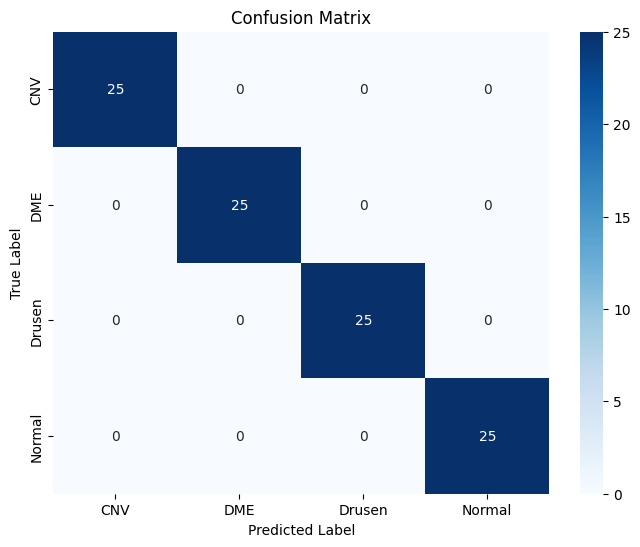

In [10]:
# Usage example
evaluator = ModelEvaluator(model=trainer.model, test_loader=test_loader)
labels, predictions = evaluator.evaluate()
evaluator.plot_confusion_matrix(labels, predictions, class_names=["CNV",  "DME","Drusen", "Normal"])

In [11]:
# Save the model
model_save_path = "efficientnet_oct_model.pth"
torch.save(trainer.model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to efficientnet_oct_model.pth


In [14]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn

# Define the image preprocessing transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the model and update it to match the saved state
def load_model(model_path, num_classes=4, device=None):
    device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Predict the class of a single image
def predict_image(model, image_path, class_names, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Make a prediction
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]

    print(f"Predicted Class: {predicted_class}")
    return predicted_class

In [16]:
# Usage example
model_path = "/content/efficientnet_oct_model.pth"
class_names = ['CNV','DME', 'Druse', 'Normal']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = load_model(model_path, num_classes=4, device=device)


<ipython-input-14-b6bdaca6e35b>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
'/content/drive/MyDrive/Projects/HDA Proj/test/DME/DME-1081406-1.jpeg'
"/content/drive/MyDrive/Projects/HDA Proj/test/NORMAL/NORMAL-12494-2.jpeg"

In [17]:
predict_image(model, '/content/drive/MyDrive/Projects/HDA Proj/test/DME/DME-1081406-1.jpeg', class_names, device)

Predicted Class: DME


'DME'